# Problem Set 1

## Question 4

Continuing with the model (4), we numerically investigate the performance of various estimators designed for static panel data models, namely, $\hat\beta_{n,\mathrm{POLS}}$, $\hat\beta_{n,\mathrm{FE}}$, $\hat\beta_{n,\mathrm{FD}}$, and the first differenced estimator using $Y_{i,t-2}$ as instrument (i.e., the IV estimator of $\beta_0$ for the first-differenced equation using $Y_{i,t-2}$ as instrument). First, for each triple $(n,T,\beta_0)$ to be specified shortly, obtain the sample as follows.

1. Simulate $\alpha_i\overset{\mathrm{iid}}{\sim} N(0,1)$ and $\epsilon_i\overset{\mathrm{iid}}{\sim} N(0,1)$.

2. Generate $Y_{i0}$ according to $Y_{i0}=0.5\alpha_i + \epsilon_i$.

3. Generate $Y_{it}$ according to (4) with $V_{it}\overset{\mathrm{iid}}{\sim} N(0,1)$.

You may then compute the aforementioned estimators with the generated sample. Repeat the above steps $1000$ times, let $\hat\beta^{(r)}$ be the estimate based on the $i$th replication (for a particular estimator), and then the finite sample bias, standard error and root mean squared error are computed as follows:

\begin{align}
    \mathrm{Bias}(\hat\beta)&=\frac{1}{1000}\sum_{r=1}^{1000}\hat\beta^{(r)} - \beta_0~,\\
    \mathrm{SE}(\hat\beta)&=\{\frac{1}{1000}\sum_{r=1}^{1000}(\hat\beta^{(r)}-\frac{1}{1000}\sum_{r=1}^{1000}\hat\beta^{(r)})^2 \}^{1/2}~,\\
    \mathrm{RMSE} (\hat\beta) & = \{[\mathrm{Bias}(\hat\beta)]^2 + [\mathrm{SE}(\hat\beta)]^2\}^{1/2}~.
\end{align}

1. Let $n=100$ and $T=6$. Graph the bias, se and rmse of each estimator as functions of $\beta_0\in\{0,0.25,0.5,0.75,1\}$.

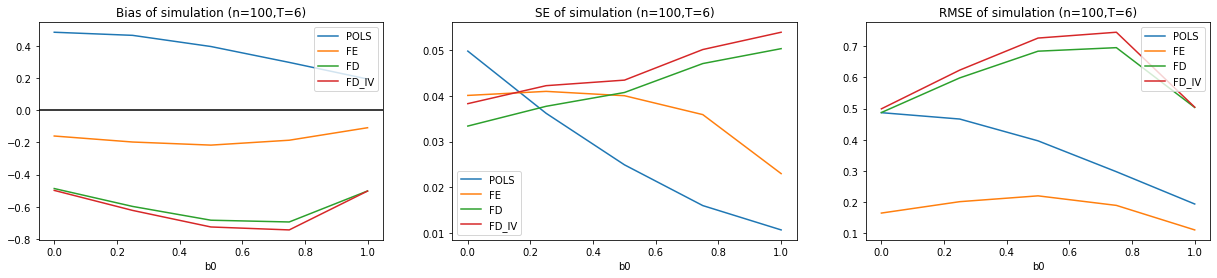

In [4]:
import os
import numpy as np
from scipy.linalg import toeplitz
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import linearmodels.panel as lm

def DGP(n,T,b0 = 0.5):
    a = np.random.normal(0,1,n)
    e = np.random.normal(0,1,n)
    
    Y0 = 0.5*a + e  # n by 1
    Ymatrix = np.zeros([n, T])  # n by T stack using reshape.
    Xmatrix = np.zeros([n, T])
    for t in range(T):
        V = np.random.normal(0,1,n)
        if t == 0:
            Y1 = b0*Y0 + a + V
            Ymatrix[:,t] = Y1
            Xmatrix[:,t] = Y0
        else:
            Y0 = Ymatrix[:,t-1]
            Y1 = b0*Y0 + a + V
            Ymatrix[:,t] = Y1
            Xmatrix[:,t] = Y0
    
    Y = Ymatrix.reshape(n*T,1)
    X = Xmatrix.reshape(n*T,1)
    
    return Y, X

def test_DGP(n,T,b0 = 0.5):
    """
    X is exogenous
    """
    a = np.random.normal(0,1,n)
    e = np.random.normal(0,1,n)
    
    Y0 = 0.5*a + e  # n by 1
    Ymatrix = np.zeros([n, T])  # n by T -> stack using reshape.
    Xmatrix = np.zeros([n, T])
    for t in range(T):
        V = np.random.normal(0,1,n)
        X = np.random.normal(0,1,n)
        Y = b0 * X + a + V        
        Ymatrix[:,t] = Y
        Xmatrix[:,t] = X
    Y = Ymatrix.reshape(n*T,1)
    X = Xmatrix.reshape(n*T,1)
    
    return Y, X

def my_OLS(Y,X):
    beta = np.linalg.inv(X.T@X) @ (X.T@Y)
    
    return beta[0]

def my_FE(Y,X,T):
    nT, k = X.shape
    n = int(nT/T)
    Qi = np.eye(T) - (np.ones(T).reshape(T,1) @ np.ones(T).reshape(1,T))/T
    Q = np.kron(np.eye(n), Qi)
    
    beta = np.linalg.inv(X.T @ Q @ X) @ (X.T @ Q @ Y)
    
    return beta[0]

def my_FD(Y,X,T):
    nT,k = X.shape
    n = int(nT/T)
    
    toep = toeplitz([-1,*np.zeros(T-2)],[0,1,*np.zeros(T-2)])
    lagY = np.kron(np.eye(n),toep) @ Y
    lagX = np.kron(np.eye(n),toep) @ X
    
    beta = my_OLS(lagY,lagX)
    
#     Y_nbyT = Y.reshape(n, T)  # [Y_{t=1}, Y_{t=2}, ..., Y_{t=T}]
#     X_nbyT = X.reshape(n, T)
#     Y_lag = Y_nbyT[:,1:].reshape([n*(T-1),1])  # [Y_{t=2}, ..., Y_{t=T}]
#     X_lag = X_nbyT[:,1:].reshape([n*(T-1),1])
    
#     dY = (Y_nbyT - Y_nbyT_lag)[:,1:].reshape([n*(T-1),1])
#     dX = (X_nbyT - X_nbyT_lag)[:,1:].reshape([n*(T-1),k])
    
#     beta = np.linalg.inv(dX.T@dX) @ (dX.T@dY)

    return beta[0]

def my_FD_IV(Y,X,T, method="2SLS"):
    nT,k = X.shape
    n = int(nT/T)
    
    Y_nbyT = Y.reshape(n, T)  # [Y_{t=1}, Y_{t=2}, ..., Y_{t=T}]
    X_nbyT = X.reshape(n, T)
    Y_nbyT_lag = np.column_stack([np.zeros(n), Y_nbyT[:,:-1]])  # [0,t=2-1,t=3-2,...]
    X_nbyT_lag = np.column_stack([np.zeros(n), X_nbyT[:,:-1]])
    
    dY = (Y_nbyT-Y_nbyT_lag)[:,2:].reshape([n*(T-2),1])  # vec[Y_{t=3-2}, Y_{t=4-3}, ...]
    dX = (X_nbyT-X_nbyT_lag)[:,2:].reshape([n*(T-2),k])  # vec[Y_{t=2-1}, Y_{t=3-2}, ...]
    iv = Y_nbyT[:,:-2].reshape([n*(T-2),1])  # vec[Y_{t=1}, Y_{t=2}, ..., Y_{t=T-2}]
    
    # 2SLS
    if method == "2SLS":
        Z = iv
        res_dY = dY - Z @ (np.linalg.inv(Z.T@Z) @ (Z.T@dY))
        res_dX = dX - Z @ (np.linalg.inv(Z.T@Z) @ (Z.T@dX))
        beta = my_OLS(res_dY,res_dX)
    if method == "IV":
        Z = np.column_stack([iv,dX])
        nom = dX.T@Z @ np.linalg.inv(Z.T@Z) @ Z.T@dY
        denom = dX.T@Z @ np.linalg.inv(Z.T@Z) @ Z.T@dX
        beta = np.linalg.inv(denom) @ nom
        beta = beta[0]

    return beta

def simulation_Q3(n,T,M=1000,test=False):
    res = []
    for b0 in [0, 0.25, 0.5, 0.75, 1]:
        res_POLS = np.zeros(M)
        res_FE = np.zeros(M)
        res_FD = np.zeros(M)
        res_FD_IV = np.zeros(M)
    
        for m in range(M):
            if test is True:
                Y, X = test_DGP(n=n,T=T,b0=b0)
            else:
                Y, X = DGP(n=n,T=T,b0=b0)
            res_POLS[m] = my_OLS(Y,X)
            res_FE[m] = my_FE(Y,X,T=T)
            res_FD[m] = my_FD(Y,X,T=T)
            res_FD_IV[m] = my_FD_IV(Y,X,T=T,method="IV")
    
        res.append({"POLS":res_POLS, "FE":res_FE,"FD":res_FD,"FD_IV":res_FD_IV})
    return res

def figure_Q3(res, n, T, save=False):
    b0 = np.array([0,0.25,0.5,0.75,1.])
    result_000 = res[0]
    
    result_000_POLS = result_000["POLS"]
    
    result_025 = res[1]
    result_050 = res[2]
    result_075 = res[3]
    result_100 = res[4]
          
    bias_POLS = [res[i]["POLS"].mean() - b0[i] for i in range(len(res))]
    bias_FE = [res[i]["FE"].mean() - b0[i] for i in range(len(res))]
    bias_FD = [res[i]["FD"].mean() - b0[i] for i in range(len(res))]
    bias_FD_IV = [res[i]["FD_IV"].mean() - b0[i] for i in range(len(res))]

    std_POLS = [res[i]["POLS"].std() for i in range(len(res))]
    std_FE = [res[i]["FE"].std() for i in range(len(res))]
    std_FD = [res[i]["FD"].std() for i in range(len(res))]
    std_FD_IV = [res[i]["FD_IV"].std() for i in range(len(res))]
    
    rmse_POLS = [np.sqrt(bias_POLS[i]**2 + std_POLS[i]**2) for i in range(len(res))]
    rmse_FE = [np.sqrt(bias_FE[i]**2 + std_FE[i]**2) for i in range(len(res))]
    rmse_FD = [np.sqrt(bias_FD[i]**2 + std_FD[i]**2) for i in range(len(res))]
    rmse_FD_IV = [np.sqrt(bias_FD_IV[i]**2 + std_FD_IV[i]**2) for i in range(len(res))]
    
    fig, ax = plt.subplots(1,3,figsize = (21,4))
    
    ax[0].plot(b0, bias_POLS)
    ax[0].plot(b0, bias_FE)
    ax[0].plot(b0, bias_FD)
    ax[0].plot(b0, bias_FD_IV)
    ax[0].axhline(0, color='black')
    ax[0].legend(["POLS", "FE", "FD", "FD_IV"])
    ax[0].set_xlabel('b0')
    ax[0].set_title("Bias of simulation (n={},T={})".format(n,T))

    ax[1].plot(b0, std_POLS)
    ax[1].plot(b0, std_FE)
    ax[1].plot(b0, std_FD)
    ax[1].plot(b0, std_FD_IV)
    ax[1].legend(["POLS", "FE", "FD", "FD_IV"])
    ax[1].set_xlabel('b0')
    ax[1].set_title("SE of simulation (n={},T={})".format(n,T))

    ax[2].plot(b0, rmse_POLS)
    ax[2].plot(b0, rmse_FE)
    ax[2].plot(b0, rmse_FD)
    ax[2].plot(b0, rmse_FD_IV)
    ax[2].legend(["POLS", "FE", "FD", "FD_IV"])
    ax[2].set_xlabel('b0')
    ax[2].set_title("RMSE of simulation (n={},T={})".format(n,T))
    
    fig.savefig('fig_n{}_T{}.jpg'.format(n,T), dpi=80)

    return fig

results_n100_T6 = simulation_Q3(n=100,T=6,M=1000)
fig_n100_T6 = figure_Q3(results_n100_T6, n=100,T=6, save=True)

In [24]:
_Y,_X = test_DGP(n=1000,T=10)
print(my_FD_IV(_Y,_X,T=10,method="2SLS"))
print(my_FD_IV(_Y,_X,T=10,method="IV"))

[0.47631595]
[0.47631571]


2. Repeat part (1) with $(n,T)=(100,3)$ and $(n,T)=(100,9)$.

In [ ]:
n,T = 100,3
results_n100_T3 = simulation_Q3(n=n,T=T,M=1000)
fig_n100_T3 = figure_Q3(results_n100_T3, n=n,T=T, save=True)

n,T = 100,9
results_n100_T9 = simulation_Q3(n=n,T=T,M=1000)
fig_n100_T9 = figure_Q3(results_n100_T9, n=n,T=T, save=True)

## Question 5

Do Exercise 17.17(a) in Hansen (2022). You will need the formula (17.93) in Hansen (2022) (see the pdf file in Canvas) for the clustered standard errors.